In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
# from keras.metrics import sparse_top_k_categorical_accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import tensorflow.keras.backend as K
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import sys
import pandas as pd
import numpy as np
from PIL import Image
import io

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
from scipy.stats import chi2_contingency
from scipy import stats
from mippiNetbuild import *
# sys.path.append('../input/mippi0801')
# from transformer import *
np.random.seed(0)

In [2]:
df_path = r'../data/processed_mutations.dataset'
# df_path = r'../../data/skempi2_window_with_pssm.dataset'
df = pd.read_pickle(df_path)

In [3]:
df.head()

,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,parAC,par0,mut1,label,mutAC1,pssm_par0,mut0_51,mut1_51,pssm_win_mut1,pssm_win_mut0
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",IKEQIKRRFEQTQEDSLYTIYELLPVWRMVLNENDLNLDSIVTQLK...,IKEQIKRRFEQTQEDSLYTIYELLPEWRMVLNENDLNLDSIVTQLK...,"[[3.0, -1.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...","[[3.0, -2.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ..."
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",NEYLDSAIKLTMQQENCNKLQNRFYNWVTSWWSDPEDKADDAMVMA...,NEYLDSAIKLTMQQENCNKLQNRFYIWVTSWWSDPEDKADDAMVMA...,"[[-1.0, 2.0, -1.0, -1.0, -2.0, 0.0, -1.0, -1.0...","[[-1.0, 1.0, 0.0, -1.0, -2.0, 0.0, 0.0, -2.0, ..."
2,EBI-10039873,[146-146],[K],[R],p.Lys146Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys146Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",LEAEAYAAFPGLGQVPKQLAQLSEAKDLQARKAFNCKYCNKEYLSL...,LEAEAYAAFPGLGQVPKQLAQLSEARDLQARKAFNCKYCNKEYLSL...,"[[-2.0, 2.0, -2.0, -4.0, -2.0, 2.0, -2.0, -5.0...","[[-2.0, 3.0, -1.0, -4.0, -2.0, 2.0, -2.0, -5.0..."
3,EBI-10039883,[187-187],[K],[R],p.Lys187Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys187Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",EYLSLGALKMHIRSHTLPCVCGTCGKAFSRPWLLQGHVRTHTGEKP...,EYLSLGALKMHIRSHTLPCVCGTCGRAFSRPWLLQGHVRTHTGEKP...,"[[3.0, 0.0, -3.0, -6.0, 2.0, 0.0, 1.0, -3.0, -...","[[3.0, 1.0, -4.0, -6.0, 2.0, -1.0, 2.0, -3.0, ..."
4,EBI-10041181,[368-368],[W],[A],p.Trp368Ala,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,P60604,MAGTALKRLMAEYKQLTLNPPEGIVAGPMNEENFFEWEALIMGPED...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Trp368Ala,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",ICWDSMQAARKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNN...,ICWDSMQAARKLPCGHLFHNSCLRSALEQDTSCPTCRMSLNIADNN...,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -1.0, 1.0...","[[-1.0, -1.0, -1.0, 2.0, 5.0, -1.0, 0.0, -2.0,..."


In [4]:
aaDict = {'0':0, 'D':1, 'S':2, 'Q':3, 'K':4,
          'I':5, 'P':6, 'T':7, 'F':8, 'N':9,
          'G':10, 'H':11, 'L':12, 'R':13, 'W':14,
          'A':15, 'V':16, 'E':17, 'Y':18, 'M':19, 'C':20}
max_len = 1024
mut0_c = [[aaDict[x] for x in a] for a in df['mut0_51']]
mut1_c = [[aaDict[x] for x in a] for a in df['mut1_51']]
par0_c = [[aaDict[x] for x in a] for a in df['par0']]
# par1_c = [[aaDict[x] for x in a] for a in df['par0']]

window_len = 51
mut0_c = keras.preprocessing.sequence.pad_sequences(mut0_c, maxlen=window_len, padding='post')
mut1_c = keras.preprocessing.sequence.pad_sequences(mut1_c, maxlen=window_len, padding='post')
par0_c = keras.preprocessing.sequence.pad_sequences(par0_c, maxlen=max_len, padding='post')

In [5]:
pssm_win_mut0 = df['pssm_win_mut0'].values
pssm_win_mut0 = np.stack(pssm_win_mut0, axis=0).astype('float32')
print(pssm_win_mut0.shape)

pssm_win_mut1 = df['pssm_win_mut1'].values
pssm_win_mut1 = np.stack(pssm_win_mut1, axis=0).astype('float32')
print(pssm_win_mut1.shape)

(16505, 51, 20)
(16505, 51, 20)


In [6]:
pssm_par0 = df['pssm_par0'].values
pssm_par0 = [x[:1024, :] for x in pssm_par0] # restrict par protein length to 1024
pssm_par0 = np.stack(pssm_par0, axis=0).astype('float32')
print(pssm_par0.shape)

(16505, 1024, 20)


In [7]:
data = [mut0_c, mut1_c, par0_c, pssm_win_mut0, pssm_win_mut1, pssm_par0]
# data = [mut0_c[:100], mut1_c[:100], par0_c[:100], pssm_win_mut0[:100], pssm_win_mut1[:100], pssm_par0[:100]]
data_reverse = [mut1_c, mut0_c, par0_c, pssm_win_mut1, pssm_win_mut0, pssm_par0]
data_no = [mut0_c, mut0_c, par0_c, pssm_win_mut0, pssm_win_mut0, pssm_par0]

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

## Model 1

In [9]:
K.clear_session()
model = build_model()
# test_model = keras.Model()

adam = optimizers.Adam(learning_rate=0.0002)

model_path = r'./via_att/s51_leaky_3block_wfl_gp_HE_no_re_cv5_best/bestAcc.h51'
# model_path = r'/lustre/home/acct-bmelgn/bmelgn-2/QianWei/MIPPI2/src/kaggle/cross_validation/activation_test/s51_leaky_3block_wfl_gp_HE/bestAcc.h51'


#model_path = r'bestAcc.h54'
model.load_weights(model_path)
model.compile(adam, loss=categorical_focal_loss(alpha=[.25, .25, .1, .25], gamma=2.), 
              metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2acc')])
model.summary()

['cn/token_and_position_embedding/embedding/embeddings:0\n', 'cn/token_and_position_embedding_1/embedding_2/embeddings:0\n', 'cn/transformer_block/multi_head_self_attention/dense/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense/bias:0\n', 'cn/transformer_block/multi_head_self_attention/dense_1/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense_1/bias:0\n', 'cn/transformer_block/multi_head_self_attention/dense_2/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense_2/bias:0\n', 'cn/transformer_block/multi_head_self_attention/dense_3/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense_3/bias:0\n', 'dense_4/kernel:0\n', 'dense_4/bias:0\n', 'dense_5/kernel:0\n', 'dense_5/bias:0\n', 'cn/transformer_block/layer_normalization/gamma:0\n', 'cn/transformer_block/layer_normalization/beta:0\n', 'cn/transformer_block/layer_normalization_1/gamma:0\n', 'cn/transformer_block/layer_normalization_1/beta:0\n', 'cn/transformer_block_1/multi_hea

In [11]:
from keras.models import Model
# layer after Softmax (LAS) (softmax)
CN = Model(inputs=model.input, outputs=model.get_layer('cn').output)

In [12]:
# create samples and fetch outputs
data_samples_list = []
for i in range(data[0].shape[0]):
    data_samples_list.append([mut0_c[i:i+1], mut1_c[i:i+1], par0_c[i:i+1], pssm_win_mut0[i:i+1], pssm_win_mut1[i:i+1], pssm_par0[i:i+1]])

In [13]:
labels = np.array(df['label'].values)
print(labels)
print(labels.shape)

[0 1 1 ... 1 3 0]
(16505,)


In [14]:
x_CN_list = []
for i in range(data[0].shape[0]):
    CN_output = CN.predict(data_samples_list[i])
    x_CN_list.append(CN_output)
x_CN = np.array(x_CN_list)
print(x_CN.shape)

(16505, 1, 4)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

fig = plt.figure()
tsne = TSNE(n_components=2, init='pca', random_state=0)

reshape = x_CN.reshape((x_CN.shape[0],-1))
print(reshape.shape)

result_CN = tsne.fit_transform(reshape)
print(result_CN.shape)
#fig = plot_embedding(result, label,'t-SNE embedding of the digits')
x_min, x_max = np.min(result_CN, 0), np.max(result_CN, 0)
result_CN = (result_CN - x_min) / (x_max - x_min)


(16505, 4)


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(16505, 2)


<Figure size 640x480 with 0 Axes>

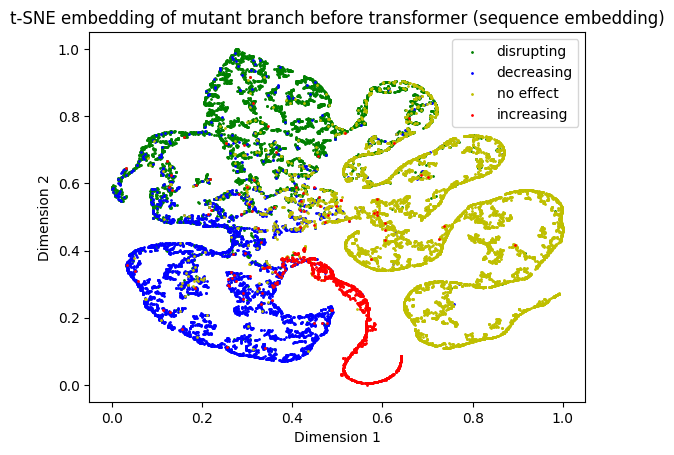

In [16]:
color = ["g","b","y","r"]
#color = ["#B0E0E6","#EE00EE"]

result = result_CN
ax = plt.subplot(111)
for i in range(result.shape[0]):
    if(labels[i] == 0): # disrupting
        s1 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
for i in range(result.shape[0]): 
    if(labels[i] == 1): # decreasing
        s2 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
for i in range(result.shape[0]): 
    if(labels[i] == 2): # no effect
        s3 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
for i in range(result.shape[0]): 
    if(labels[i] == 3): # increasing
        s4 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE embedding of mutant branch before transformer (sequence embedding)')
plt.legend((s1,s2,s3,s4),('disrupting','decreasing','no effect','increasing') ,loc = 'best')
plt.show()

In [33]:
x_PLBT_list = []
for i in range(data[0].shape[0]):
    PLBT_output = PLBT.predict(data_samples_list[i])
    x_PLBT_list.append(PLBT_output)
x_PLBT = np.array(x_PLBT_list)
print(x_PLBT.shape)

MemoryError: Unable to allocate 4.03 GiB for an array with shape (16505, 1, 1024, 64) and data type float32

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

fig = plt.figure()
tsne = TSNE(n_components=2, init='pca', random_state=0)

reshape = x_PLBT.reshape((x_PLBT.shape[0],-1))
print(reshape.shape)

result_PLBT = tsne.fit_transform(reshape)
print(result_PLBT.shape)
#fig = plot_embedding(result, label,'t-SNE embedding of the digits')
x_min, x_max = np.min(result_PLBT, 0), np.max(result_PLBT, 0)
result = (result_PLBT - x_min) / (x_max - x_min)

In [ ]:
color = ["r","y","b","g"]
#color = ["#B0E0E6","#EE00EE"]

result = result_PLBT
ax = plt.subplot(111)
for i in range(result.shape[0]):
    if(labels[i] == 0):
        s1 = plt.scatter(result[i, 0], result[i, 1],s=3,color=color[labels[i]])
for i in range(result.shape[0]):
    if(labels[i] == 1):
        s2 = plt.scatter(result[i, 0], result[i, 1],s=3,color=color[labels[i]])
for i in range(result.shape[0]):
    if(labels[i] == 2):
        s3 = plt.scatter(result[i, 0], result[i, 1],s=3,color=color[labels[i]])
for i in range(result.shape[0]):
    if(labels[i] == 3):
        s4 = plt.scatter(result[i, 0], result[i, 1],s=3,color=color[labels[i]])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE embedding of partner branch before transformer (sequence embedding)')
plt.legend((s1,s2,s3,s4),('disrupting','decreasing','no effect','increasing') ,loc = 'best')
plt.show()

In [13]:
x_LAG_list = []
for i in range(data[0].shape[0]):
    LAG_output = LAG.predict(data_samples_list[i])
    x_LAG_list.append(LAG_output)
x_LAG = np.array(x_LAG_list)
print(x_LAG.shape)

(16505, 1, 4)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

fig = plt.figure()
tsne = TSNE(n_components=2, init='pca', random_state=0)

reshape_LAG = x_LAG.reshape((x_LAG.shape[0],-1))
print(reshape_LAG.shape)

result_LAG = tsne.fit_transform(reshape_LAG)
print(result_LAG.shape)
#fig = plot_embedding(result, label,'t-SNE embedding of the digits')
x_min, x_max = np.min(result_LAG, 0), np.max(result_LAG, 0)
result_LAG = (result_LAG - x_min) / (x_max - x_min)

(16505, 4)


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(16505, 2)


<Figure size 640x480 with 0 Axes>

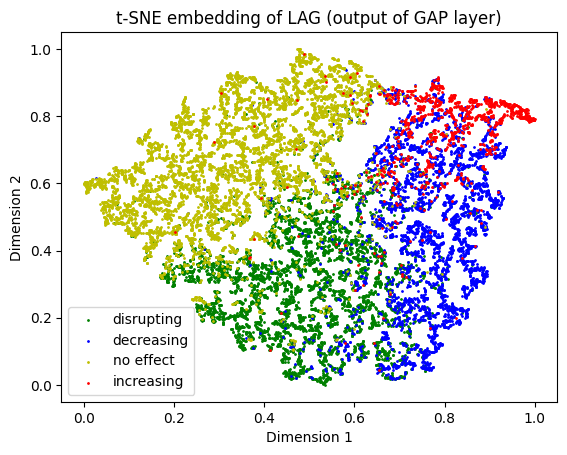

In [15]:
#color = ["r","#FFFF00","b","#228B22"]
#color = ["#EE6363","#DAA520","#48D1CC","#6B8E23"]
color = ["g","b","y","r"]

result = result_LAG
ax = plt.subplot(111)
for i in range(result.shape[0]):
    if(labels[i] == 0): # disrupting
        s1 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'disrupting')
for i in range(result.shape[0]): 
    if(labels[i] == 1): # decreasing
        s2 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'decreasing')
for i in range(result.shape[0]): 
    if(labels[i] == 2): # no effect
        s3 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'no effect')
for i in range(result.shape[0]): 
    if(labels[i] == 3): # increasing
        s4 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'increasing')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE embedding of LAG (output of GAP layer)')
plt.legend((s1,s2,s3,s4),('disrupting','decreasing','no effect','increasing') ,loc = 'best')
plt.savefig("tSNE.png",dpi=300)
plt.show()


In [37]:
# Umap draw
import umap
reducer = umap.UMAP(random_state=100)
umap_LAG = reducer.fit_transform(reshape_LAG)
x_min, x_max = np.min(umap_LAG, 0), np.max(umap_LAG, 0)
umap_LAG = (umap_LAG- x_min) / (x_max - x_min)

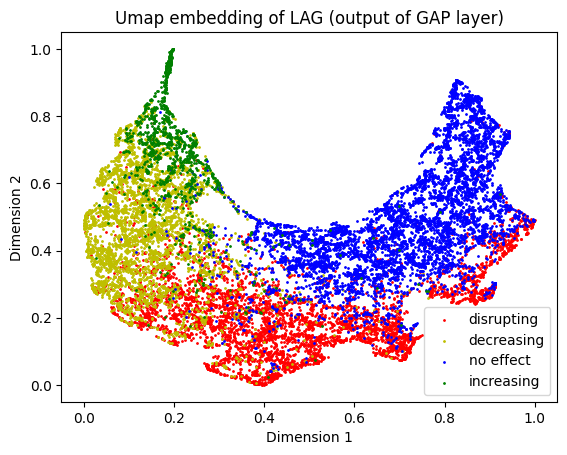

In [38]:
# Umap draw
color = ["r","y","b","g"]
#color = ["#EE6363","#DAA520","#48D1CC","#6B8E23"]

result = umap_LAG
ax = plt.subplot(111)
for i in range(result.shape[0]):
    if(labels[i] == 0): # disrupting
        s1 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'disrupting')
for i in range(result.shape[0]): 
    if(labels[i] == 1): # decreasing
        s2 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'decreasing')
for i in range(result.shape[0]): 
    if(labels[i] == 2): # no effect
        s3 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'no effect')
for i in range(result.shape[0]): 
    if(labels[i] == 3): # increasing
        s4 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]],label = 'increasing')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Umap embedding of LAG (output of GAP layer)')
plt.legend((s1,s2,s3,s4),('disrupting','decreasing','no effect','increasing') ,loc = 'best')
plt.show()

In [28]:
x_LAS_list = []
for i in range(data[0].shape[0]):
    LAS_output = LAS.predict(data_samples_list[i])
    x_LAS_list.append(LAS_output)
x_LAS = np.array(x_LAS_list)
print(x_LAS.shape)

(16505, 1, 4)


In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

fig = plt.figure()
tsne = TSNE(n_components=2, init='pca', random_state=0)

reshape_LAS = x_LAS.reshape((x_LAS.shape[0],-1))
print(reshape_LAS.shape)

result_LAS = tsne.fit_transform(reshape_LAS)
print(result_LAS.shape)
#fig = plot_embedding(result, label,'t-SNE embedding of the digits')
x_min, x_max = np.min(result_LAS, 0), np.max(result_LAS, 0)
result_LAS = (result_LAS - x_min) / (x_max - x_min)

(16505, 4)


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(16505, 2)


<Figure size 640x480 with 0 Axes>

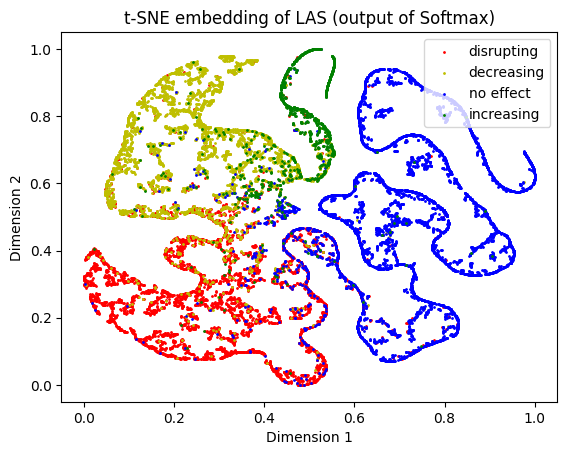

In [30]:
color = ["r","y","b","g"]
#color = ["#EE6363","#DAA520","#48D1CC","#6B8E23"]

result = result_LAS
ax = plt.subplot(111)
for i in range(result.shape[0]):
    if(labels[i] == 0): # disrupting
        s1 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
for i in range(result.shape[0]): 
    if(labels[i] == 1): # decreasing
        s2 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
for i in range(result.shape[0]): 
    if(labels[i] == 2): # no effect
        s3 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
for i in range(result.shape[0]): 
    if(labels[i] == 3): # increasing
        s4 = plt.scatter(result[i, 0], result[i, 1],s=1,color=color[labels[i]])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE embedding of LAS (output of Softmax)')
plt.legend((s1,s2,s3,s4),('disrupting','decreasing','no effect','increasing') ,loc = 'best')
plt.show()